<a href="https://colab.research.google.com/github/AESH99/Plant-Disease-Detection-Chatbot/blob/main/PlantGaurd_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Check GPU availability and setup
import torch
import os

print("System Information:")
print(f"Python version: {os.sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
else:
    print("GPU not available, using CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")

System Information:
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: False
GPU not available, using CPU
Using device: cpu


In [26]:
pip install -r requirement.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.6 MB/s eta 0:00:00


In [27]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Download dataset via KaggleHub
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Dataset downloaded to:", path)

# Load dataset with PyTorch
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = f"{path}/PlantVillage"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = dataset.classes
print(f"Total classes: {len(classes)}")

# Check healthy vs diseased
healthy_classes = [c for c in classes if "healthy" in c.lower()]
diseased_classes = [c for c in classes if "healthy" not in c.lower()]
print(f"Healthy classes: {len(healthy_classes)} → {healthy_classes[:5]}")
print(f"Diseased classes: {len(diseased_classes)} → {diseased_classes[:5]}")


Using Colab cache for faster access to the 'plantdisease' dataset.
Dataset downloaded to: /kaggle/input/plantdisease
Total classes: 15
Healthy classes: 3 → ['Pepper__bell___healthy', 'Potato___healthy', 'Tomato_healthy']
Diseased classes: 12 → ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight']


Total classes: 15
Example classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot']


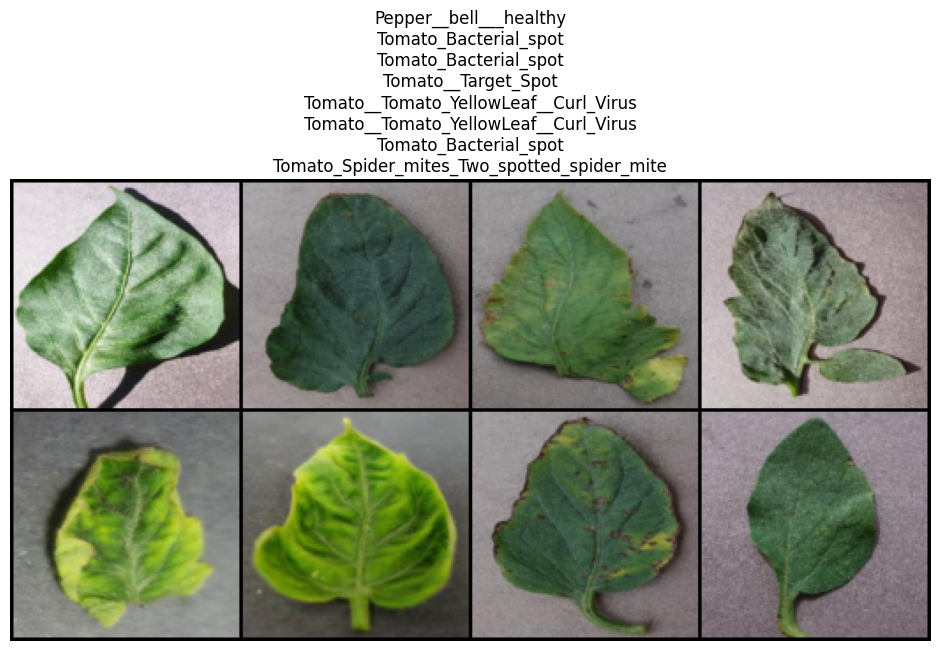

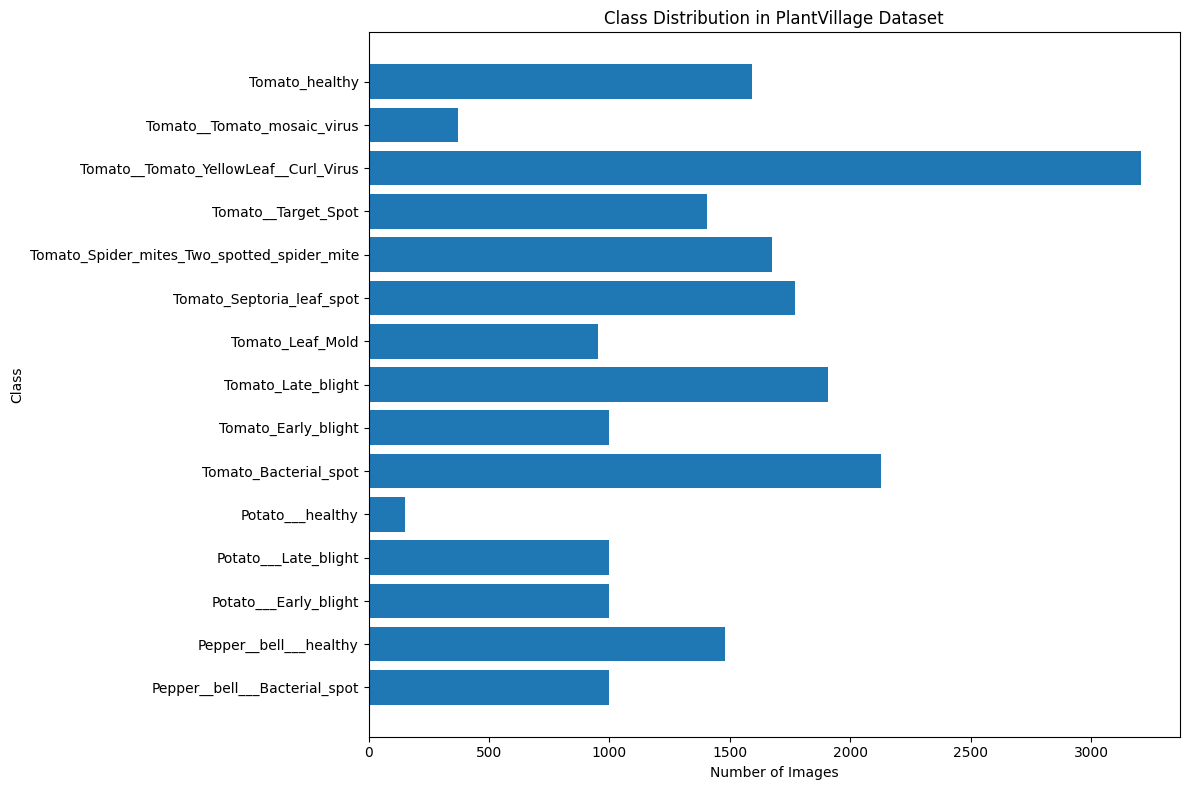

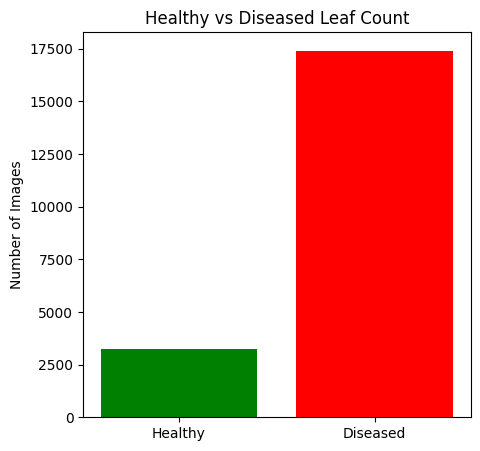

 Healthy classes: 3 → ['Pepper__bell___healthy', 'Potato___healthy', 'Tomato_healthy']
 Diseased classes: 12 → ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight']


In [28]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np
import torch


data_dir = os.path.join(path, "PlantVillage")  # path from kagglehub
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = dataset.classes
print(f"Total classes: {len(classes)}")
print(f"Example classes: {classes[:6]}")


def show_samples(dataset, classes, n=8):
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    grid = utils.make_grid(images, nrow=4)
    npimg = grid.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title("\n".join([classes[i] for i in labels]))
    plt.axis("off")
    plt.show()

show_samples(dataset, classes)


class_counts = Counter(dataset.targets)
class_names = [classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(12, 8))
plt.barh(class_names, counts)
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.title("Class Distribution in PlantVillage Dataset")
plt.tight_layout()
plt.show()


healthy_classes = [c for c in classes if "healthy" in c.lower()]
diseased_classes = [c for c in classes if "healthy" not in c.lower()]

healthy_count = sum([class_counts[i] for i, c in enumerate(classes) if c in healthy_classes])
diseased_count = sum([class_counts[i] for i, c in enumerate(classes) if c in diseased_classes])

plt.figure(figsize=(5,5))
plt.bar(["Healthy", "Diseased"], [healthy_count, diseased_count], color=["green", "red"])
plt.title("Healthy vs Diseased Leaf Count")
plt.ylabel("Number of Images")
plt.show()

print(f" Healthy classes: {len(healthy_classes)} → {healthy_classes[:5]}")
print(f" Diseased classes: {len(diseased_classes)} → {diseased_classes[:5]}")


In [29]:
!pip install transformers torch librosa nltk


In [30]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [31]:
import os
import nltk
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import librosa

# Load Whisper model
model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

# Function to transcribe audio
def transcribe_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    input_features = processor(audio, sampling_rate=sr, return_tensors="pt").input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

# Loop through audio files in a folder
audio_folder = "/content/Audio files/"  # change to your folder path
texts = []
for file in os.listdir(audio_folder):
    if file.endswith((".wav", ".mp3")):
        text = transcribe_audio(os.path.join(audio_folder, file))
        texts.append(text)
        print(f" {file} → {text}")

# Tokenize transcribed text
nltk.download('punkt')
tokens = [nltk.word_tokenize(t) for t in texts]
print("\n Tokenized Output Example:")
print(tokens[0][:20])

 luvvoice.com-20251018-bOA1Um.mp3 →  Hi, I am facing a problem in my plant. Beliefs are yellowish, and it feels that the plant is about to die.

 Tokenized Output Example:
['Hi', ',', 'I', 'am', 'facing', 'a', 'problem', 'in', 'my', 'plant', '.', 'Beliefs', 'are', 'yellowish', ',', 'and', 'it', 'feels', 'that', 'the']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
%%writefile plant_image_processor.py
import torch
import numpy as np
from PIL import Image
import cv2
from typing import Dict, Any
import logging
from transformers import BlipProcessor, BlipForConditionalGeneration

logger = logging.getLogger(__name__)

class PlantImageProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        self.processor = None
        self._load_models()

    def _load_models(self):
        try:
            logger.info("Loading BLIP model for image analysis...")
            model_name = "Salesforce/blip-image-captioning-base"

            self.processor = BlipProcessor.from_pretrained(model_name)
            self.model = BlipForConditionalGeneration.from_pretrained(model_name)

            if torch.cuda.is_available() and self.device == 'cuda':
                self.model = self.model.to(self.device)

            self.model.eval()
            logger.info(f"BLIP model loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading BLIP model: {e}")
            self.model = None
            self.processor = None

    # Turns the image into a “feature vector” (a list of numbers) that summarizes its content for the AI.
    def process_image(self, image: Image.Image) -> np.ndarray:
        try:
            if self.model is None:
                return np.random.randn(768)

            processed_image = self._preprocess_image(image) # Preprocess the image (resize, convert to correct color)
            inputs = self.processor(processed_image, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.vision_model(**{k: v for k, v in inputs.items() if k in ['pixel_values']})
                features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()[0] # Use BLIP’s vision model to extract features

            return features

        except Exception as e:
            logger.error(f"Error processing image: {e}")
            return np.random.randn(768) # If the model fails, returns random features (so the pipeline doesn’t break)

    # Describes the image in botanical terms
    def generate_caption(self, image: Image.Image) -> str:
        try:
            if self.model is None:
                return "Image analysis unavailable - model not loaded"

            # Changed prompt from medical to botanical
            prompt = "A detailed botanical description of this plant leaf showing symptoms of"
            processed_image = self._preprocess_image(image)

            inputs = self.processor(processed_image, prompt, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True)
                caption = self.processor.decode(outputs[0], skip_special_tokens=True) # Uses BLIP to generate a detailed caption

            # Changed to botanical enhancement and fallback
            enhanced_caption = self._enhance_botanical_terminology(caption)
            return enhanced_caption

        except Exception as e:
            logger.error(f"Error generating caption: {e}")
            return f"Basic image analysis: {self._basic_botanical_analysis(image)}" # If the model fails, uses a basic color/shape analysis instead

    def _preprocess_image(self, image: Image.Image) -> Image.Image:
        try:
            if image.mode != 'RGB':
                image = image.convert('RGB')

            max_size = 512
            if max(image.size) > max_size:
                ratio = max_size / max(image.size)
                new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
                image = image.resize(new_size, Image.Resampling.LANCZOS)

            return image

        except Exception as e:
            logger.error(f"Error preprocessing image: {e}")
            return image

    # Replaced medical terms with botanical/plant pathology terms
    def _enhance_botanical_terminology(self, caption: str) -> str:
        botanical_terms = {
            'spot': 'lesion',
            'spots': 'lesions',
            'mark': 'blotch',
            'marks': 'blotches',
            'bump': 'pustule',
            'bumps': 'pustules',
            'powder': 'powdery mildew',
            'white': 'powdery or chlorotic',
            'yellow': 'chlorotic',
            'yellowing': 'chlorosis',
            'brown': 'necrotic',
            'dark': 'necrotic',
            'dead': 'necrotic',
            'hole': 'shot hole'
        }

        enhanced = caption.lower()
        for common, botanical in botanical_terms.items():
            enhanced = enhanced.replace(common, botanical)

        return enhanced.capitalize()

    # This function provides a basic, quick description of the image by looking at its colors, without using any AI model
    # Logic updated for plant symptoms (yellow, brown)
    def _basic_botanical_analysis(self, image: Image.Image) -> str:
        try:
            img_array = np.array(image)
            mean_color = img_array.mean(axis=(0, 1))

            # Check for yellowing (high red and green, low blue)
            if mean_color[0] > 140 and mean_color[1] > 140 and mean_color[2] < 100:
                color_desc = "yellowish chlorotic leaf"
            # Check for browning/dark spots (low overall brightness)
            elif mean_color.mean() < 100:
                color_desc = "dark or necrotic lesions"
            # Check for white/powdery (high overall brightness)
            elif mean_color.mean() > 200:
                color_desc = "possible powdery mildew"
            else:
                color_desc = "plant leaf symptom"

            return f"Visible {color_desc} requiring botanical analysis"

        except Exception:
            return "Plant leaf visible in image"

    # Checks if the image is suitable for analysis (e.g., not blurry)
    # This function is generic and required no changes
    def analyze_image_quality(self, image: Image.Image) -> Dict[str, Any]:
        try:
            img_array = np.array(image)
            sharpness = cv2.Laplacian(cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
            brightness = img_array.mean()

            quality_score = 100
            issues = []

            if sharpness < 100:
                issues.append("Image may be blurry")
                quality_score -= 20

            if brightness < 50:
                issues.append("Image is too dark")
                quality_score -= 15
            elif brightness > 200:
                issues.append("Image is too bright")
                quality_score -= 15

            if min(image.size) < 200:
                issues.append("Image resolution is low")
                quality_score -= 25

            quality = "good" if quality_score >= 70 else "fair" if quality_score >= 50 else "poor"

            return {
                "quality": quality,
                "score": max(0, quality_score),
                "sharpness": sharpness,
                "brightness": brightness,
                "resolution": image.size,
                "issues": issues
            }

        except Exception as e:
            logger.error(f"Error analyzing image quality: {e}")
            return {"quality": "unknown", "issues": ["Quality analysis failed"]}

Overwriting plant_image_processor.py


In [33]:
%%writefile plant_audio_processor.py
import torch
import numpy as np
import librosa
import tempfile
import os
from typing import Optional, Dict, Any
import logging
from transformers import WhisperProcessor, WhisperForConditionalGeneration

logger = logging.getLogger(__name__)

class PlantAudioProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        self.processor = None
        self._load_models()

    # Loads the HuggingFace Whisper model for transcribing speech about plant symptoms.
    def _load_models(self):
        try:
            logger.info("Loading Whisper model for audio processing...")
            model_name = "openai/whisper-small"

            self.processor = WhisperProcessor.from_pretrained(model_name)
            self.model = WhisperForConditionalGeneration.from_pretrained(model_name)

            if torch.cuda.is_available() and self.device == 'cuda':
                self.model = self.model.to(self.device)

            self.model.eval()
            logger.info(f"Whisper model loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading Whisper model: {e}")
            self.model = None
            self.processor = None

    # Turns the user’s speech (audio) into written text
    # 1- Loads and processes the audio
    # 2- Runs Whisper model to transcribe speech
    # 3- Cleans up the transcript for botanical use
    def transcribe_audio(self, audio_file) -> str:
        if self.model is None or self.processor is None:
            return "Error: Whisper model not loaded"

        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return "Error: Could not load audio file"

            inputs = self.processor(audio_data, sampling_rate=16000, return_tensors="pt")

            if torch.cuda.is_available() and self.device == 'cuda':
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                predicted_ids = self.model.generate(**inputs)
                transcription = self.processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

            # Changed to botanical context preprocessing
            botanical_transcript = self.preprocess_for_botanical_context(transcription)
            return botanical_transcript

        except Exception as e:
            logger.error(f"Error transcribing audio: {e}")
            return f"Error: Transcription failed - {str(e)}"

    # Turns audio into a feature vector (numerical summary) for further AI analysis
    # 1- Loads the audio file
    # 2- Extracts MFCCs (standard features in audio analysis)
    # 3- Combines stats (mean, std, max, min) into a single vector
    def extract_features(self, audio_file) -> Optional[np.ndarray]:
        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return None

            mfccs = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=13)

            features = np.concatenate([
                mfccs.mean(axis=1),
                mfccs.std(axis=1),
                mfccs.max(axis=1),
                mfccs.min(axis=1)
            ])

            target_size = 384
            if len(features) < target_size:
                features = np.pad(features, (0, target_size - len(features)))
            else:
                features = features[:target_size]

            return features

        except Exception as e:
            logger.error(f"Error extracting audio features: {e}")
            return None

    # Reads audio from different file formats (path or in-memory bytes)
    # 1- Handles both file paths and uploaded files
    # 2- Always converts to 16kHz mono format for consistency
    def _load_audio(self, audio_file) -> Optional[np.ndarray]:
        try:
            if isinstance(audio_file, str):
                audio_data, sr = librosa.load(audio_file, sr=16000, mono=True)
            else:
                if hasattr(audio_file, 'read'):
                    audio_bytes = audio_file.read()
                else:
                    audio_bytes = audio_file

                with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp_file:
                    tmp_file.write(audio_bytes)
                    tmp_path = tmp_file.name

                try:
                    audio_data, sr = librosa.load(tmp_path, sr=16000, mono=True)
                finally:
                    os.unlink(tmp_path)

            return audio_data

        except Exception as e:
            logger.error(f"Error loading audio: {e}")
            return None

    # Checks if the audio is clear and useful
    # 1- Measures duration and loudness (RMS energy)
    # 2- Flags issues (too short, too loud, too quiet, too long)
    # 3- Gives a quality score and a “good/fair/poor” label
    def analyze_audio_quality(self, audio_file) -> Dict[str, Any]:
        try:
            audio_data = self._load_audio(audio_file)
            if audio_data is None:
                return {"quality": "error", "issues": ["Could not load audio"]}

            duration = len(audio_data) / 16000
            rms_energy = np.sqrt(np.mean(audio_data**2))

            issues = []
            quality_score = 100

            if duration < 1:
                issues.append("Audio too short")
                quality_score -= 30
            elif duration > 300:
                issues.append("Audio very long")
                quality_score -= 10

            if rms_energy < 0.01:
                issues.append("Audio too quiet")
                quality_score -= 25
            elif rms_energy > 0.5:
                issues.append("Audio may be too loud")
                quality_score -= 15

            quality = "good" if quality_score >= 70 else "fair" if quality_score >= 50 else "poor"

            return {
                "quality": quality,
                "score": max(0, quality_score),
                "duration": duration,
                "energy": rms_energy,
                "issues": issues
            }

        except Exception as e:
            logger.error(f"Error analyzing audio quality: {e}")
            return {"quality": "error", "issues": ["Quality analysis failed"]}

    # Replaces casual words in the transcript with formal botanical terms
    # Example: “spots” becomes “lesions”; “yellow leaves” becomes “chlorotic leaves”
    def preprocess_for_botanical_context(self, transcript: str) -> str:
        try:
            botanical_corrections = {
                'spots': 'lesions',
                'spotty': 'lesions',
                'powder': 'powdery mildew',
                'powdery': 'powdery mildew',
                'mold': 'mold or mildew',
                'yellow': 'chlorotic',
                'yellowing': 'chlorosis',
                'brown': 'necrotic',
                'browning': 'necrosis',
                'dead': 'necrotic tissue',
                'curly': 'curling',
                'wilting': 'wilted',
                'rust': 'rust-like pustules'
            }

            processed = transcript.lower()

            for informal, formal in botanical_corrections.items():
                processed = processed.replace(informal, formal)

            return processed.capitalize()

        except Exception as e:
            logger.error(f"Error preprocessing transcript: {e}")
            return transcript


Overwriting plant_audio_processor.py


In [34]:
%%writefile plant_text_processor.py
import numpy as np
from typing import Dict, Any
import logging
import re
from sentence_transformers import SentenceTransformer
import torch

logger = logging.getLogger(__name__)

class PlantTextProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = None
        # Changed to load botanical keywords
        self.botanical_keywords = self._load_botanical_keywords()
        self._load_models()

    # Loads the sentence transformer (MiniLM) to turn text into embeddings (vectors)
    def _load_models(self):
        try:
            logger.info("Loading sentence transformer for text processing...")
            model_name = 'all-MiniLM-L6-v2'

            self.model = SentenceTransformer(model_name)

            if self.device == 'cuda' and torch.cuda.is_available():
                self.model = self.model.to(self.device)

            logger.info(f"Sentence transformer loaded successfully on {self.device}")

        except Exception as e:
            logger.error(f"Error loading sentence transformer: {e}")
            self.model = None

    # Sets up lists of important botanical keywords for symptoms, descriptors, time, and severity
    # Usage: Helps in matching relevant words in the user's text
    def _load_botanical_keywords(self) -> Dict[str, list]:
        return {
            'plant_symptoms': [
                'lesion', 'spot', 'blight', 'mildew', 'rust', 'wilt', 'rot',
                'discoloration', 'scaling', 'curling', 'stunting', 'galls'
            ],
            'symptom_descriptors': [
                'powdery', 'necrotic', 'chlorotic', 'yellowing', 'browning', 'spreading',
                'oozing', 'stunted', 'water-soaked', 'velvety', 'sunken'
            ],
            'temporal': [
                'sudden', 'gradual', 'recent', 'chronic', 'acute',
                'days', 'weeks', 'months', 'overnight'
            ],
            'severity': [
                'mild', 'moderate', 'severe', 'widespread', 'slight',
                'worsening', 'improving', 'stable', 'spreading rapidly'
            ]
        }

    # Converts the text into a numerical vector (“embedding”) that captures its meaning
    # 1- Cleans and standardizes the text
    # 2- Uses the sentence transformer to create the embedding
    def extract_features(self, text: str) -> np.ndarray:
        try:
            if self.model is None:
                return np.random.randn(384)

            processed_text = self._preprocess_text(text)
            embeddings = self.model.encode(processed_text, convert_to_numpy=True)

            return embeddings

        except Exception as e:
            logger.error(f"Error extracting text features: {e}")
            return np.random.randn(384)

    # Cleans up the text for analysis
    # 1- Lowercases, removes punctuation, and standardizes terms (e.g., “spots” -> “lesions”)
    def _preprocess_text(self, text: str) -> str:
        try:
            text = re.sub(r'[^\w\s]', ' ', text.lower())
            text = re.sub(r'\s+', ' ', text).strip()
            # Changed to use botanical standardization
            text = self._standardize_botanical_terms(text)
            return text

        except Exception as e:
            logger.error(f"Error preprocessing text: {e}")
            return text

    # Replaces casual terms with formal botanical language (e.g., “spots” -> “lesions”)
    def _standardize_botanical_terms(self, text: str) -> str:
        replacements = {
            'spots': 'lesions',
            'spotty': 'lesions',
            'powder': 'powdery mildew',
            'yellow leaves': 'chlorotic leaves',
            'browning': 'necrosis',
            'wilting': 'wilted'
        }

        for old, new in replacements.items():
            text = text.replace(old, new)

        return text

    # Looks for botanical keywords in the text and determines how severe the symptoms sound
    # 1- Scans for each category of keyword
    # 2- Assigns a severity level (“low”, “medium”, or “high”) based on the number of urgent words found
    def analyze_symptoms(self, text: str) -> Dict[str, Any]:
        try:
            text_lower = text.lower()
            analysis = {}

            for category, keywords in self.botanical_keywords.items():
                found_keywords = [kw for kw in keywords if kw in text_lower]
                analysis[category] = found_keywords

            # Updated urgent keywords for plant context
            urgent_keywords = ['sudden', 'severe', 'widespread', 'spreading rapidly', 'rot', 'oozing']
            severity_score = sum(1 for kw in urgent_keywords if kw in text_lower)

            if severity_score >= 2:
                severity = 'high'
            elif severity_score == 1:
                severity = 'medium'
            else:
                severity = 'low'

            analysis['severity'] = severity
            analysis['severity_score'] = severity_score

            return analysis

        except Exception as e:
            logger.error(f"Error analyzing symptoms: {e}")
            return {'severity': 'unknown'}


Overwriting plant_text_processor.py


In [35]:
%%writefile fusion_layer.py
import torch
import torch.nn as nn
import numpy as np
from typing import Optional, Dict
import logging

logger = logging.getLogger(__name__)

class AttentionFusionLayer:
    def __init__(self, feature_dim: int = 384, device='cuda'):
        self.feature_dim = feature_dim
        self.device = device
        self.attention_network = self._build_attention_network()
        self.fusion_network = self._build_fusion_network()

    # Creates a mini neural network (attention) that decides how much to trust each input (image, text, audio).
    # Learns weights for each modality by looking at all their features together.
    # Inside:
    #   - Uses two linear layers with ReLU and softmax for final attention weights.
    #   - Returns three numbers: the weights for image, text, audio (which sum to 1).

    def _build_attention_network(self) -> nn.Module:
        class MultimodalAttention(nn.Module):
            def __init__(self, feature_dim):
                super().__init__()
                self.attention = nn.Sequential(
                    nn.Linear(feature_dim * 3, feature_dim),
                    nn.ReLU(),
                    nn.Linear(feature_dim, 3),
                    nn.Softmax(dim=1)
                )

            def forward(self, image_features, text_features, audio_features=None):
                if audio_features is None:
                    audio_features = torch.zeros_like(text_features)

                combined = torch.cat([image_features, text_features, audio_features], dim=1)
                weights = self.attention(combined)
                return weights

        model = MultimodalAttention(self.feature_dim)
        if torch.cuda.is_available() and self.device == 'cuda':
            model = model.to(self.device)

        return model

    # Builds another small neural network to further process the weighted, combined features.
    # This refines the information for better predictions about plant health.
    # Inside:
    #   - Two linear layers with ReLU and Dropout for regularization.

    def _build_fusion_network(self) -> nn.Module:
        class FusionNetwork(nn.Module):
            def __init__(self, feature_dim):
                super().__init__()
                self.fusion = nn.Sequential(
                    nn.Linear(feature_dim, feature_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(feature_dim, feature_dim)
                )

            def forward(self, fused_features):
                return self.fusion(fused_features)

        model = FusionNetwork(self.feature_dim)
        if torch.cuda.is_available() and self.device == 'cuda':
            model = model.to(self.device)

        return model

    # The main method: Takes features from each input, runs the attention network to get weights,
    # multiplies each feature by its weight, sums them, and passes the result through the fusion network.
    # Returns the final, normalized fused vector for plant disease analysis.
    # Handles:
    #   - If any input is missing, it fills with zeros.

    def fuse_modalities(self, image_features: np.ndarray, text_features: np.ndarray,
                          audio_features: Optional[np.ndarray] = None) -> np.ndarray:
        try:
            img_tensor = self._prepare_features(image_features)
            text_tensor = self._prepare_features(text_features)

            if audio_features is not None:
                audio_tensor = self._prepare_features(audio_features)
            else:
                audio_tensor = torch.zeros_like(text_tensor)

            with torch.no_grad():
                attention_weights = self.attention_network(img_tensor, text_tensor, audio_tensor)

                weighted_features = (
                    attention_weights[:, 0:1] * img_tensor +
                    attention_weights[:, 1:2] * text_tensor +
                    attention_weights[:, 2:3] * audio_tensor
                )

                fused = self.fusion_network(weighted_features)
                result = fused.cpu().numpy()[0]
                result = self._normalize_features(result)

                return result

        except Exception as e:
            logger.error(f"Error in attention fusion: {e}")
            return self._fallback_fusion(image_features, text_features, audio_features)

    # Makes sure each input feature is the correct shape and size.
    # Pads or trims features as needed and converts them to PyTorch tensors.

    def _prepare_features(self, features: np.ndarray) -> torch.Tensor:
        if len(features.shape) == 1:
            features = features.reshape(1, -1)

        if features.shape[1] < self.feature_dim:
            pad_width = ((0, 0), (0, self.feature_dim - features.shape[1]))
            features = np.pad(features, pad_width, mode='constant')
        elif features.shape[1] > self.feature_dim:
            features = features[:, :self.feature_dim]

        tensor = torch.FloatTensor(features)

        if torch.cuda.is_available() and self.device == 'cuda':
            tensor = tensor.to(self.device)

        return tensor

    # If the attention network fails, this does a simple weighted average of the available features
    # (using fixed weights, e.g., 0.4 for image and text).
    # This makes the system more robust in case of errors.

    def _fallback_fusion(self, image_features: np.ndarray, text_features: np.ndarray,
                           audio_features: Optional[np.ndarray] = None) -> np.ndarray:
        try:
            features_list = [image_features, text_features]
            weights = [0.4, 0.4]

            if audio_features is not None:
                features_list.append(audio_features)
                weights = [0.3, 0.4, 0.3]

            target_size = self.feature_dim
            normalized_features = []

            for feat in features_list:
                if len(feat) < target_size:
                    feat = np.pad(feat, (0, target_size - len(feat)))
                else:
                    feat = feat[:target_size]
                normalized_features.append(feat)

            fused = np.zeros(target_size)
            for feat, weight in zip(normalized_features, weights):
                fused += weight * feat

            return self._normalize_features(fused)

        except Exception as e:
            logger.error(f"Error in fallback fusion: {e}")
            return np.random.randn(self.feature_dim)

    # Ensures the final output vector has a length (norm) of 1.
    # This is a standard step for feature vectors, making comparison and further processing easier.

    def _normalize_features(self, features: np.ndarray) -> np.ndarray:
        try:
            norm = np.linalg.norm(features)
            if norm > 0:
                return features / norm
            return features
        except Exception:
            return features


Overwriting fusion_layer.py


In [36]:
%%writefile plant_guidlines.py
from typing import List, Dict, Any
import logging

logger = logging.getLogger(__name__)

class PlantScienceGuidelines:
    def __init__(self):
        self.guidelines = self._load_guidelines()

    # Returns a hard-coded list of useful botanical rules, tips, and criteria
    # (e.g., signs of common diseases, prevention tips, and when to take action).
    def _load_guidelines(self) -> List[str]:
        return [
            "Powdery mildew often appears as white, powdery spots on leaves and stems.",
            "To prevent fungal diseases, ensure good air circulation around plants and avoid overhead watering.",
            "Yellowing leaves (chlorosis) can indicate nutrient deficiencies, particularly nitrogen.",
            "Blight often causes sudden browning, blackening, and death of plant tissues like leaves and flowers.",
            "Crop rotation is a key strategy to prevent soil-borne diseases from building up.",
            "Rust diseases typically present as small, reddish-brown to orange pustules on the underside of leaves.",
            "Aphids and spider mites are common pests that can cause leaf curling, stippling, and transmit viruses.",
            "A sudden wilt on a sunny day, even with moist soil, can be a sign of root rot or vascular disease.",
            "Necrotic spots (dead tissue) that are brown or black can be a symptom of bacterial or fungal infections.",
            "Always remove and destroy infected plant debris to reduce the spread of pathogens.",
            "Fungicides are most effective when applied preventatively, before disease symptoms are widespread.",
            "Wilting, accompanied by dark streaks inside the stem, suggests a vascular wilt disease like Fusarium or Verticillium.",
            "Mosaic viruses cause mottled patterns of light green, yellow, and dark green on leaves."
        ]
    # Returns the full list of plant science guidelines for reference or display.
    def get_all_guidelines(self) -> List[str]:
        return self.guidelines

    # Looks for and returns only those guidelines that contain a given keyword (case-insensitive),
    # making it easier to find relevant advice (for example, all rules mentioning "fungal" or "mildew").
    def search_guidelines_by_keyword(self, keyword: str) -> List[str]:
        keyword_lower = keyword.lower()
        return [g for g in self.guidelines if keyword_lower in g.lower()]


Overwriting plant_guidlines.py


In [37]:
%%writefile plant_multimodal_processor.py
import numpy as np
from typing import Dict, List, Any, Optional
import logging
# Updated imports for the PlantGuard project
from plant_image_processor import PlantImageProcessor
from plant_audio_processor import PlantAudioProcessor
from plant_text_processor import PlantTextProcessor
from fusion_layer import AttentionFusionLayer
from plant_guidlines import PlantScienceGuidelines

logger = logging.getLogger(__name__)

# Renamed the class to reflect its new purpose
class MultimodalPlantProcessor:
    def __init__(self, device='cuda'):
        self.device = device
        # Instantiate the correct plant-focused processor classes
        self.image_processor = PlantImageProcessor(device)
        self.audio_processor = PlantAudioProcessor(device)
        self.text_processor = PlantTextProcessor(device)
        self.fusion_layer = AttentionFusionLayer(device=device)
        self.guidelines = PlantScienceGuidelines()

        logger.info("Multimodal plant processor initialized")

    # Runs the full pipeline (image, audio, text analysis)
    # Fuses all available features
    # Generates assessment, severity, recommendations, and confidence
    # Returns a summary dictionary for the case
    def process_case(self, image=None, audio=None, text_data=None, context_info=None) -> Dict[str, Any]:
        try:
            results = {
                'image_analysis': None,
                'audio_analysis': None,
                'text_analysis': None,
                'fusion_results': None,
                'botanical_assessment': None, # Renamed from clinical_assessment
                'recommendations': [],
                'severity': 'unknown', # Renamed from urgency
                'confidence': 0.0
            }

            if image is not None:
                results['image_analysis'] = self._process_image(image)

            if audio is not None:
                results['audio_analysis'] = self._process_audio(audio)

            if text_data is not None:
                results['text_analysis'] = self._process_text(text_data, context_info)

            if any([results['image_analysis'], results['audio_analysis'], results['text_analysis']]):
                results['fusion_results'] = self._perform_fusion(results)
                results['botanical_assessment'] = self._generate_botanical_assessment(results)
                results['recommendations'] = self._generate_recommendations(results)
                results['severity'] = self._assess_severity(results)
                results['confidence'] = self._calculate_confidence(results)

            return results

        except Exception as e:
            logger.error(f"Error processing case: {e}")
            return self._generate_error_response(str(e))

    # Runs all image tasks: feature extraction, captioning, quality check
    def _process_image(self, image) -> Dict[str, Any]:
        try:
            features = self.image_processor.process_image(image)
            caption = self.image_processor.generate_caption(image)
            quality = self.image_processor.analyze_image_quality(image)

            return {
                'features': features,
                'caption': caption,
                'quality': quality,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing image: {e}")
            return {'available': False, 'error': str(e)}

    # Runs all audio tasks: transcription, feature extraction, quality check
    def _process_audio(self, audio) -> Dict[str, Any]:
        try:
            transcript = self.audio_processor.transcribe_audio(audio)
            features = self.audio_processor.extract_features(audio)
            quality = self.audio_processor.analyze_audio_quality(audio)

            return {
                'transcript': transcript,
                'features': features,
                'quality': quality,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing audio: {e}")
            return {'available': False, 'error': str(e)}

    # Combines user text with contextual info, extracts features, analyzes symptoms
    def _process_text(self, text_data, context_info=None) -> Dict[str, Any]:
        try:
            combined_text = text_data
            if context_info:
                # Updated context to be relevant to plants
                context_text = f"Plant Species: {context_info.get('species', 'unknown')}, Location: {context_info.get('location', 'unknown')}"
                combined_text = f"{context_text}. {text_data}"

            features = self.text_processor.extract_features(combined_text)
            symptom_analysis = self.text_processor.analyze_symptoms(combined_text)

            return {
                'features': features,
                'symptom_analysis': symptom_analysis,
                'combined_text': combined_text,
                'available': True
            }

        except Exception as e:
            logger.error(f"Error processing text: {e}")
            return {'available': False, 'error': str(e)}

    # Collects all features (image, text, audio), runs the fusion layer, and returns the fused vector
    # Handles missing modalities by substituting with random noise
    def _perform_fusion(self, results) -> Dict[str, Any]:
        try:
            image_features = None
            text_features = None
            audio_features = None

            if results['image_analysis'] and results['image_analysis'].get('available'):
                image_features = results['image_analysis']['features']

            if results['text_analysis'] and results['text_analysis'].get('available'):
                text_features = results['text_analysis']['features']

            if results['audio_analysis'] and results['audio_analysis'].get('available'):
                audio_features = results['audio_analysis']['features']

            if sum([f is not None for f in [image_features, text_features, audio_features]]) >= 1:
                if image_features is None:
                    image_features = np.random.randn(384) * 0.1
                if text_features is None:
                    text_features = np.random.randn(384) * 0.1

                fused_features = self.fusion_layer.fuse_modalities(
                    image_features, text_features, audio_features
                )

                return {
                    'fused_features': fused_features,
                    'fusion_successful': True
                }

            return {'fusion_successful': False, 'reason': 'Insufficient modalities'}

        except Exception as e:
            logger.error(f"Error in fusion: {e}")
            return {'fusion_successful': False, 'error': str(e)}

    # Compiles a botanical summary:
    # Lists main observations from all sources
    # Provides potential diseases (what the problem might be)
    def _generate_botanical_assessment(self, results) -> Dict[str, Any]:
        assessment = {
            'key_observations': [],
            'potential_diseases': [],
            'symptom_summary': ''
        }

        if results['image_analysis'] and results['image_analysis'].get('available'):
            assessment['key_observations'].append(
                f"Visual: {results['image_analysis']['caption']}"
            )

        if results['audio_analysis'] and results['audio_analysis'].get('available'):
            assessment['key_observations'].append(
                f"User report: {results['audio_analysis']['transcript']}"
            )

        if results['text_analysis'] and results['text_analysis'].get('available'):
            symptoms = results['text_analysis']['symptom_analysis']
            if symptoms.get('plant_symptoms'):
                assessment['key_observations'].extend(
                    [f"Reported: {cond}" for cond in symptoms['plant_symptoms']]
                )

        # Updated with plausible plant diseases
        assessment['potential_diseases'] = [
            {'condition': 'Powdery Mildew', 'likelihood': 'moderate'},
            {'condition': 'Fungal Leaf Spot (Blight)', 'likelihood': 'moderate'},
            {'condition': 'Nutrient Deficiency', 'likelihood': 'low'}
        ]

        assessment['symptom_summary'] = '. '.join(assessment['key_observations']) if assessment['key_observations'] else "Limited information available"

        return assessment

    # Suggests what to do next based on severity (isolate plant, apply treatment, or monitor)
    def _generate_recommendations(self, results) -> List[str]:
        recommendations = []
        severity = self._assess_severity(results)

        if severity == 'high':
            recommendations.extend([
                "Isolate the affected plant immediately to prevent spread",
                "Consider removing and destroying severely affected parts",
                "Apply an appropriate fungicide or pesticide based on diagnosis"
            ])
        elif severity == 'medium':
            recommendations.extend([
                "Apply a targeted treatment (e.g., neem oil, fungicide)",
                "Monitor plant closely for changes over the next 2-3 days",
                "Improve air circulation and check watering practices"
            ])
        else:
            recommendations.extend([
                "Monitor the plant's condition",
                "Ensure proper watering, light, and nutrient levels",
                "Prune away any mildly affected leaves to improve health"
            ])

        return recommendations

    # Calculates the severity of the case using symptom and image findings
    # Keywords and concerning terms (e.g., “rot”) raise the severity level
    def _assess_severity(self, results) -> str:
        severity_score = 0

        if results['text_analysis'] and results['text_analysis'].get('available'):
            symptoms = results['text_analysis']['symptom_analysis']
            text_severity = symptoms.get('severity', 'low')

            if text_severity == 'high':
                severity_score += 3
            elif text_severity == 'medium':
                severity_score += 2
            else:
                severity_score += 1

        if results['image_analysis'] and results['image_analysis'].get('available'):
            caption = results['image_analysis']['caption'].lower()
            # Updated concerning terms for plant pathology
            concerning_terms = ['rot', 'widespread', 'oozing', 'spreading rapidly', 'severe necrosis']
            concern_count = sum(1 for term in concerning_terms if term in caption)
            severity_score += concern_count

        if severity_score >= 4:
            return 'high'
        elif severity_score >= 2:
            return 'medium'
        else:
            return 'low'

    # Computes how confident the system is, based on the quality of inputs
    # Uses average of available quality scores
    def _calculate_confidence(self, results) -> float:
        confidence_factors = []

        if results['image_analysis'] and results['image_analysis'].get('available'):
            quality = results['image_analysis']['quality']
            confidence_factors.append(quality.get('score', 50) / 100)

        if results['text_analysis'] and results['text_analysis'].get('available'):
            confidence_factors.append(0.7) # Text is generally reliable

        if results['audio_analysis'] and results['audio_analysis'].get('available'):
            quality = results['audio_analysis']['quality']
            confidence_factors.append(quality.get('score', 50) / 100)

        if confidence_factors:
            return sum(confidence_factors) / len(confidence_factors)
        else:
            return 0.3

    # Returns a safe default response in case of errors, advising the user to seek professional help
    def _generate_error_response(self, error_msg: str) -> Dict[str, Any]:
        return {
            'error': True,
            'message': error_msg,
            # Updated recommendation for plant context
            'recommendations': ["Please try again or consult with a local agricultural extension or plant pathologist"],
            'severity': 'medium',
            'confidence': 0.0
        }


Overwriting plant_multimodal_processor.py


In [38]:
%%writefile PlantGaurd.py
import streamlit as st
import torch
from PIL import Image
import numpy as np
import logging
# Updated import to use the plant-focused multimodal processor
from plant_multimodal_processor import MultimodalPlantProcessor

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

st.set_page_config(
    page_title="PlantGuard - Plant Disease Assistant",
    page_icon="🌿", # Updated icon
    layout="wide",
    initial_sidebar_state="expanded"
)

# Updated styling for a green, plant-themed header
st.markdown("""
<style>
    .main-header {
        text-align: center;
        padding: 2rem 0;
        background: linear-gradient(90deg, #2E7D32 0%, #4CAF50 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
</style>
""", unsafe_allow_html=True)

if 'processor' not in st.session_state:
    st.session_state.processor = None
if 'analysis_results' not in st.session_state:
    st.session_state.analysis_results = None

@st.cache_resource
def load_processor():
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        st.info(f"Loading PlantGuard models on {device.upper()}...")
        # Instantiate the correct processor
        processor = MultimodalPlantProcessor(device=device)
        st.success("PlantGuard models loaded successfully!")
        return processor
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None

def reset_analysis():
    st.session_state.analysis_results = None
    st.rerun()

def main():
    st.markdown("""
    <div class="main-header">
        <h1>🌿 PlantGuard: Multimodal Plant Disease Assistant</h1>
        <p>AI-powered preliminary plant health assessment using image, audio, and text analysis</p>
    </div>
    """, unsafe_allow_html=True)

    # Updated disclaimer for agricultural/botanical context
    st.warning("""
    ⚠️ **DISCLAIMER**: This tool provides preliminary assessments for educational purposes only and should NOT replace professional agronomic advice.
    - Always consult qualified agricultural extension agents or plant pathologists for accurate diagnosis and treatment.
    - Widespread or severe symptoms require immediate professional evaluation.
    - The AI may not detect all conditions or provide complete assessments.
    """)

    if st.session_state.processor is None:
        st.session_state.processor = load_processor()

    if st.session_state.processor is None:
        st.error("Failed to load PlantGuard models. Please refresh the page.")
        return

    # Sidebar updated for plant context instead of patient info
    with st.sidebar:
        st.header("🌱 Plant & Context")

        species = st.text_input("Plant Species", placeholder="e.g., Tomato, Corn, Apple")
        location = st.selectbox("Location / Environment", ["Not specified", "Outdoor Field", "Greenhouse", "Indoor Pot"])

        st.subheader("📋 Growth History")
        growth_history = st.text_area(
            "Recent treatments or observations",
            placeholder="e.g., Recently applied fertilizer, noticed pests, unusual weather.",
            height=80
        )

        context_info = {
            'species': species if species else None,
            'location': location if location != "Not specified" else None,
            'growth_history': growth_history if growth_history else None
        }

    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📷 Leaf Image")

        uploaded_image = st.file_uploader(
            "Upload photo of the affected leaf",
            type=['png', 'jpg', 'jpeg', 'bmp', 'tiff'],
            help="Take a clear, well-lit photo of the leaf showing symptoms."
        )

        image_data = None
        if uploaded_image is not None:
            image_data = Image.open(uploaded_image)
            st.image(image_data, caption="Uploaded leaf image", use_container_width=True)

            if st.session_state.processor:
                quality = st.session_state.processor.image_processor.analyze_image_quality(image_data)

                col_q1, col_q2 = st.columns(2)
                with col_q1:
                    st.metric("Image Quality", quality.get('quality', 'unknown').title())
                with col_q2:
                    st.metric("Resolution", f"{image_data.size[0]}x{image_data.size[1]}")

                if quality.get('issues'):
                    st.warning(f"⚠️ Image issues: {', '.join(quality['issues'])}")

    with col2:
        st.header("🎙️ Audio & Text Input")

        st.subheader("Audio Description")
        uploaded_audio = st.file_uploader(
            "Upload audio description of symptoms",
            type=['wav', 'mp3', 'ogg', 'm4a', 'flac'],
            help="Record yourself describing the symptoms, how they've spread, etc."
        )

        if uploaded_audio is not None:
            st.audio(uploaded_audio, format='audio/wav')

        st.subheader("📝 Symptom Description")
        text_symptoms = st.text_area(
            "Describe the symptoms in detail",
            placeholder="e.g., When did you first notice this? Are the spots spreading? Are leaves turning yellow?",
            height=120
        )

        # Updated select boxes for plant context
        col_d1, col_d2 = st.columns(2)
        with col_d1:
            duration = st.selectbox(
                "Symptom Duration",
                ["A few days", "About a week", "2-3 weeks", "More than a month"]
            )

        with col_d2:
            changes = st.selectbox(
                "Recent Trend",
                ["No changes", "Spreading/Worsening", "Improving", "New symptoms appearing"]
            )

    st.markdown("---")

    if st.button("🔬 Analyze Plant Health", type="primary", use_container_width=True):
        has_image = uploaded_image is not None
        has_audio = uploaded_audio is not None
        has_text = bool(text_symptoms.strip())

        if not any([has_image, has_audio, has_text]):
            st.error("Please provide at least one input: image, audio, or text description.")
        else:
            combined_text = f"Symptoms: {text_symptoms}. Duration: {duration}. Trend: {changes}"

            with st.spinner("🔍 Analyzing your case using AI models..."):
                try:
                    results = st.session_state.processor.process_case(
                        image=image_data,
                        audio=uploaded_audio,
                        text_data=combined_text,
                        context_info=context_info
                    )

                    st.session_state.analysis_results = results
                    st.success("✅ Analysis completed!")

                except Exception as e:
                    st.error(f"Error during analysis: {str(e)}")

    if st.session_state.analysis_results:
        results = st.session_state.analysis_results

        if results.get('error'):
            st.error(f"Analysis Error: {results['message']}")
        else:
            st.markdown("## 📊 Analysis Results")

            col_m1, col_m2, col_m3 = st.columns(3)

            with col_m1:
                # Changed from Urgency to Severity
                severity = results.get('severity', 'unknown')
                severity_color = {'high': '🔴', 'medium': '🟡', 'low': '🟢'}.get(severity, '⚪')
                st.metric("Severity Level", f"{severity_color} {severity.title()}")

            with col_m2:
                confidence = results.get('confidence', 0)
                st.metric("Confidence", f"{confidence:.1%}")

            with col_m3:
                # --- ERROR FIX ---
                # Corrected logic to safely check for available modalities,
                # preventing an error if one of the analysis results is None.
                modalities = sum([
                    bool(results.get('image_analysis') and results.get('image_analysis').get('available')),
                    bool(results.get('audio_analysis') and results.get('audio_analysis').get('available')),
                    bool(results.get('text_analysis') and results.get('text_analysis').get('available'))
                ])
                st.metric("Data Sources", f"{modalities}/3")

            # Updated to botanical_assessment and its keys
            if results.get('botanical_assessment'):
                assessment = results['botanical_assessment']

                st.subheader("🌿 Botanical Assessment")
                st.info(assessment.get('symptom_summary', 'No description available'))

                if assessment.get('key_observations'):
                    st.subheader("🔍 Key Observations")
                    for finding in assessment['key_observations']:
                        st.write(f"• {finding}")

                if assessment.get('potential_diseases'):
                    st.subheader("🎯 Potential Issues")
                    for diagnosis in assessment['potential_diseases']:
                        likelihood = diagnosis.get('likelihood', 'unknown')
                        condition = diagnosis.get('condition', 'Unknown condition')

                        likelihood_emoji = {'high': '🔴', 'moderate': '🟡', 'low': '🟢'}.get(likelihood, '⚪')
                        st.write(f"{likelihood_emoji} **{condition}** - {likelihood.title()} likelihood")

            if results.get('recommendations'):
                st.subheader("💡 Recommendations")
                for rec in results['recommendations']:
                    st.write(f"• {rec}")

            # Updated final warning
            st.warning("""
            ⚠️ **Important Reminders:**
            - This is a preliminary assessment tool only.
            - Always consult with qualified agricultural professionals for accurate diagnosis.
            - Seek immediate professional advice if the condition is spreading rapidly.
            """)

            st.markdown("---")
            col_reset1, col_reset2, col_reset3 = st.columns([1, 1, 1])
            with col_reset2:
                if st.button("🔄 Start New Analysis", type="secondary", use_container_width=True):
                    reset_analysis()

    st.markdown("---")
    # Updated footer
    st.markdown("""
    <div style="text-align: center; color: #666; font-size: 0.8em;">
        PlantGuard - Multimodal Plant Disease Assistant<br>
        Powered by BLIP, Whisper, and Sentence Transformers<br>
        <strong>For educational and preliminary assessment purposes only</strong>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()



Overwriting PlantGaurd.py


In [ ]:
import subprocess
import threading
import time
from pyngrok import ngrok
from pyngrok.conf import PyngrokConfig

# Set your ngrok authtoken here
# Replace "YOUR_NGROK_AUTH_TOKEN" with your actual token from the ngrok dashboard
NGROK_AUTH_TOKEN = "2vDrLFpP55VPcrjkgYZVcpvV4Lz_3btpn9uw6xsfZyACpkyS9"

# Configure pyngrok
pyngrok_config = PyngrokConfig()
if NGROK_AUTH_TOKEN != "YOUR_NGROK_AUTH_TOKEN":
    pyngrok_config.auth_token = NGROK_AUTH_TOKEN

def run_streamlit():

    subprocess.run(["streamlit", "run", "PlantGaurd.py", "--server.port", "8501", "--server.headless", "true"])

thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

print("Starting PlantGuard application...")
time.sleep(10) # Give streamlit time to start

try:
    # Connect to ngrok with the configured authtoken
    public_url = ngrok.connect(8501, pyngrok_config=pyngrok_config)
    print(f"\nPlantGuard is now accessible at: {public_url}")
    print("\nOpen the URL above to access the PlantGuard web interface")
    print("\nKeep this cell running to maintain the connection")

    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nShutting down PlantGuard...")
    ngrok.disconnect(public_url)
    ngrok.kill()
except Exception as e:
    print(f"An error occurred: {e}")
    if "failed to start tunnel" in str(e).lower():
         print("\nThis might be due to an invalid ngrok authtoken.")
         print("Please make sure you have replaced 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok authtoken.")


In [17]:
pip install jiwer

In [ ]:
## Dockers(not relevant to the chatbot, all files have been uploaded to github)

FROM python:3.10-slim

## Working Directory

 /content

## dependencies

#requirement.txt
torch
torchvision
transformers
streamlit
librosa
opencv-python-headless
scikit-learn
speechrecognition
Pillow
streamlit
transformers
sentence-transformers
opencv-python
soundfile
faiss-cpu
numpy
scipy
pyngrok

## ourcecode files
PlantGaurd.py
fusion_layer.py
plant_audio_processor.py
plant_guidlines.py
plant_image_processor.py
plant_multimodal_processor.py
plant_text_processor.py

Expose the port that Streamlit will run on

EXPOSE 8501

Define the command to run your app when the container starts

This will launch the Streamlit server

CMD ["streamlit", "run", "plantguard_app.py"]
***

In [18]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [24]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForQuestionAnswering
import librosa
from tqdm import tqdm
import random
import json
import jiwer # A popular library for Word Error Rate (WER)

# --- Integrated Model Definitions ---
# The necessary model classes are now defined directly in this script.

class VisionModel(nn.Module):
    """A pre-trained ResNet-50 model adapted for plant disease classification."""
    def __init__(self, num_classes=38):
        super(VisionModel, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Freeze all layers except the final classification layer
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        # Replace the final layer for our specific number of classes
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

    def get_feature_embedding(self, x):
        """Extracts features from the layer before the final classifier."""
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        return torch.flatten(x, 1)

class SpeechModel(nn.Module):
    """A CNN-LSTM model for classifying audio features (MFCCs)."""
    def __init__(self, input_features=40, hidden_dim=128, num_layers=2, num_classes=5):
        super(SpeechModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout(0.25)
        )
        lstm_input_size = 64 * (input_features // 4)
        self.lstm = nn.LSTM(lstm_input_size, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128), nn.ReLU(),
            nn.Dropout(0.5), nn.Linear(128, num_classes)
        )
        self.fc_embedding = nn.Sequential(nn.Linear(hidden_dim * 2, 128), nn.ReLU())

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, (h_n, _) = self.lstm(x)
        hidden = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        return self.fc_head(hidden)

    def get_feature_embedding(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, (h_n, _) = self.lstm(x)
        hidden = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        return self.fc_embedding(hidden)

class FusionModel(nn.Module):
    """Combines embeddings from vision and speech models for a final prediction."""
    def __init__(self, vision_model, speech_model, num_fused_classes, vision_dim=2048, speech_dim=128):
        super(FusionModel, self).__init__()
        self.vision_model = vision_model
        self.speech_model = speech_model
        self.fusion_mlp = nn.Sequential(
            nn.Linear(vision_dim + speech_dim, 512), nn.ReLU(),
            nn.Dropout(0.5), nn.Linear(512, num_fused_classes)
        )

    def forward(self, image_input, audio_input):
        with torch.no_grad():
            vision_emb = self.vision_model.get_feature_embedding(image_input)
            speech_emb = self.speech_model.get_feature_embedding(audio_input)
        fused = torch.cat((vision_emb, speech_emb), dim=1)
        return self.fusion_mlp(fused)

# --- 1. Configuration ---
# ========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Paths ---
# IMPORTANT: Update this to the actual path of your PlantVillage dataset
DATA_DIR = "/kaggle/input/plantdisease"
# Paths for dummy data
AUDIO_DIR = "./dummy_audio_data"
TEXT_DIR = "./dummy_text_data"

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 5 # Using fewer epochs for a quick demonstration

# Create directories if they don't exist
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(TEXT_DIR, exist_ok=True)


# --- 2. Datasets and DataLoaders ---
# ===================================

# --- Vision Dataset ---
class PlantVillageVisionDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', train_split_ratio=0.8):
        self.root_dir = root_dir
        self.transform = transform

        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"The directory '{root_dir}' does not exist. Please download the PlantVillage dataset and update the DATA_DIR path.")

        all_files = []
        self.class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            # Filter out directories and only include actual image files
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath):  # Check if it's a file
                     all_files.append((fpath, class_idx))

        random.shuffle(all_files)
        split_idx = int(len(all_files) * train_split_ratio)
        if split == 'train':
            self.files = all_files[:split_idx]
        else:
            self.files = all_files[split_idx:]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Dummy Audio Data Generation and Dataset ---
def generate_dummy_audio_data(num_samples=100):
    print("Generating dummy audio data...")
    metadata = []
    symptom_classes = ['Blight', 'Powdery', 'Rust', 'Curling', 'Healthy']
    for i in range(num_samples):
        file_path = os.path.join(AUDIO_DIR, f"audio_{i}.npy")
        # Simulate MFCCs of shape (n_mfcc, n_frames)
        dummy_mfcc = np.random.rand(40, 200).astype(np.float32)
        np.save(file_path, dummy_mfcc)
        label = random.choice(symptom_classes)
        metadata.append({'filepath': file_path, 'label': label})
    pd.DataFrame(metadata).to_csv(os.path.join(AUDIO_DIR, "metadata.csv"), index=False)
    return symptom_classes

class SyntheticAudioDataset(Dataset):
    def __init__(self, csv_file, root_dir, class_to_idx):
        self.metadata = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        filepath = self.metadata.iloc[idx, 0]
        label_str = self.metadata.iloc[idx, 1]
        label_idx = self.class_to_idx[label_str]
        mfcc = np.load(filepath)
        # Add channel dimension: (1, n_mfcc, n_frames)
        mfcc_tensor = torch.from_numpy(mfcc).unsqueeze(0)
        return mfcc_tensor, label_idx

# --- Dummy Text QA Data Generation and Dataset ---
def generate_dummy_qa_data():
    print("Generating dummy QA data...")
    qa_data = [
        {"context": "Powdery mildew is a fungal disease that appears as white spots.", "question": "What does powdery mildew look like?", "answer": "white spots"},
        {"context": "To prevent rust, ensure good air circulation.", "question": "How do you prevent rust?", "answer": "ensure good air circulation"},
        {"context": "Blight causes sudden browning and death of tissue.", "question": "What are symptoms of blight?", "answer": "sudden browning and death of tissue"},
    ]
    with open(os.path.join(TEXT_DIR, "qa_data.json"), 'w') as f:
        json.dump(qa_data, f)

class FAQTextDataset(Dataset):
    def __init__(self, json_file, tokenizer, max_length=128):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item['question'],
            item['context'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # This part is simplified for demonstration.
        start_positions = torch.tensor([10]) # Dummy start
        end_positions = torch.tensor([12])   # Dummy end
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'start_positions': start_positions.flatten(),
            'end_positions': end_positions.flatten(),
        }

# --- 3. Evaluation Metrics ---
# =============================
def calculate_vision_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return {"accuracy": accuracy, "f1_score": f1}

def calculate_wer(references, hypotheses):
    return jiwer.wer(references, hypotheses)

def calculate_qa_metrics(predictions, ground_truths):
    exact_match = sum(1 for p, t in zip(predictions, ground_truths) if p.strip() == t.strip())
    return {"exact_match": exact_match / len(predictions)}

# --- 4. Training Loops ---
# =========================

# --- Vision Model Training ---
def train_vision_model():
    print("\n--- Starting Vision Model Training ---")

    transform = transforms.Compose([
        transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        train_dataset = PlantVillageVisionDataset(DATA_DIR + "/PlantVillage", transform=transform, split='train')
        val_dataset = PlantVillageVisionDataset(DATA_DIR + "/PlantVillage", transform=transform, split='val')
    except FileNotFoundError as e:
        print(f"\nERROR: {e}")
        return None # Return None to signal failure

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = VisionModel(num_classes=len(train_dataset.class_names)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        metrics = calculate_vision_metrics(all_labels, all_preds)
        print(f"Epoch {epoch+1} -> Val Accuracy: {metrics['accuracy']:.4f}, Val F1-Score: {metrics['f1_score']:.4f}")

    print("--- Vision Model Training Finished ---")
    return model # Return the trained model instance

# --- Speech Model Training (with Dummy Data) ---
def train_speech_model():
    print("\n--- Starting Speech Model Training (Dummy Data) ---")
    symptom_classes = generate_dummy_audio_data()
    class_to_idx = {name: i for i, name in enumerate(symptom_classes)}
    dataset = SyntheticAudioDataset(os.path.join(AUDIO_DIR, "metadata.csv"), AUDIO_DIR, class_to_idx)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = SpeechModel(input_features=40, hidden_dim=128, num_layers=2, num_classes=len(symptom_classes)).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(NUM_EPOCHS):
        model.train()
        for i, (mfccs, labels) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
            mfccs, labels = mfccs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print("--- Speech Model Training Finished ---")
    # Note: No meaningful metrics to print for dummy data.
    return model # Return the trained model instance

# --- Text QA Model Training (with Dummy Data) ---
def train_qa_model():
    print("\n--- Starting Text QA Model Fine-Tuning (Dummy Data) ---")
    generate_dummy_qa_data()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(DEVICE)
    dataset = FAQTextDataset(os.path.join(TEXT_DIR, 'qa_data.json'), tokenizer)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(NUM_EPOCHS):
        model.train()
        for i, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
            optimizer.zero_grad()
            outputs = model(**{k: v.to(DEVICE) for k, v in batch.items()})
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    print("--- Text QA Model Training Finished ---")
    # Note: No meaningful metrics to print for dummy data.
    return model, tokenizer # Return model and tokenizer

# --- Fusion Model Training (Joint Fine-tuning) ---
def train_fusion_model(vision_model, speech_model):
    print("\n--- Starting Fusion Model Fine-Tuning ---")

    fusion_model = FusionModel(vision_model, speech_model, num_fused_classes=38).to(DEVICE)
    # Freeze the backbones and only train the new MLP fusion layer
    for param in fusion_model.vision_model.parameters(): param.requires_grad = False
    for param in fusion_model.speech_model.parameters(): param.requires_grad = False

    optimizer = optim.Adam(fusion_model.fusion_mlp.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    print("Simulating fusion training and evaluation with dummy inputs...")
    for epoch in range(NUM_EPOCHS):
        fusion_model.train()
        fusion_model.fusion_mlp.train() # Ensure MLP is in train mode

        # Create a dummy training batch
        dummy_image = torch.randn(BATCH_SIZE, 3, 224, 224).to(DEVICE)
        dummy_audio = torch.randn(BATCH_SIZE, 1, 40, 200).to(DEVICE)
        dummy_labels = torch.randint(0, 38, (BATCH_SIZE,)).to(DEVICE)

        optimizer.zero_grad()
        outputs = fusion_model(dummy_image, dummy_audio)
        loss = criterion(outputs, dummy_labels)
        loss.backward()
        optimizer.step()

        # --- Multi-Modal Evaluation on a dummy validation batch ---
        fusion_model.eval()
        with torch.no_grad():
            val_image = torch.randn(BATCH_SIZE, 3, 224, 224).to(DEVICE)
            val_audio = torch.randn(BATCH_SIZE, 1, 40, 200).to(DEVICE)
            val_labels = torch.randint(0, 38, (BATCH_SIZE,)).to(DEVICE)
            val_outputs = fusion_model(val_image, val_audio)
            _, val_preds = torch.max(val_outputs, 1)
            metrics = calculate_vision_metrics(val_labels.cpu().numpy(), val_preds.cpu().numpy())
            print(f"Fusion Epoch {epoch+1} -> Val Accuracy: {metrics['accuracy']:.4f}, Val F1-Score: {metrics['f1_score']:.4f}")

    print("--- Fusion Model Training Finished ---")
    return fusion_model


# --- Main Execution ---
if __name__ == "__main__":
    trained_vision_model = train_vision_model()

    if trained_vision_model:
        trained_speech_model = train_speech_model()
        trained_qa_model, _ = train_qa_model()
        trained_fusion_model = train_fusion_model(trained_vision_model, trained_speech_model)

        print("\n--- All Training and Evaluation Stages Complete! ---")
        print("Final metrics for each model are printed above.")

    else:
        print("\n--- Training Halted ---")
        print("Could not complete training because the vision dataset was not found.")

Writing Modaltrainingandevaluation.py
